# **Goal** :
This notebook aims at producing TOD in a very simplified manner : project the QUBIC beam on the sky, take the value of the pixel, and add it to the TOD. 
This simplified TOD production will be used to test the convergence issue of the TOD with Nsub, and in particular to test our hypothesis about the pixellisation effect.

# Importation

In [1]:

import numpy as np
import matplotlib.pyplot as plt
import healpy as hp

from tqdm import tqdm

from qubic.lib.Qdictionary import qubicDict
from qubic.lib.Instrument.Qacquisition import QubicMultiAcquisitions, compute_freq
from qubic.lib.Qsamplings import get_pointing, equ2gal
from qubic.lib.Qscene import QubicScene
from qubic.lib.MapMaking.FrequencyMapMaking.Qspectra_component import CMBModel

%matplotlib inline

In [2]:
nside = 128

# Initialize QUBIC instance

Build the QUBIC dictionary, mandatory to use the QUBIC functions

In [3]:
# Build MPI communicator and qubic dict
dictfilename = 'qubic/qubic/dicts/pipeline_demo.dict'
d = qubicDict()
d.read_from_file(dictfilename)

center = equ2gal(d['RA_center'], d['DEC_center'])

d['nf_recon'] = 2
d['MultiBand'] = True
d['nside'] = nside

d['npointings'] = 20
d['synthbeam_kmax'] = 1
d['synthbeam_fraction'] = 1

d['noiseless'] = True
d['photon_noise'] = False
d['use_synthbeam_fits_file'] = False

In [4]:
# Build scanning strategy
sampling = get_pointing(d)

# Build scene
scene = QubicScene(d)

In [5]:
# Number of sub-acquisitions
nsub_max = 104
nsub_list = np.arange(4, nsub_max + 1, 4)

In [6]:
# Build CMB map
cl_cmb = CMBModel(None).give_cl_cmb(r=0, Alens=1)
cmb_map = hp.synfast(cl_cmb, nside, new=True, verbose=False).T

In [7]:
# Build acquisition operator
Qacq = QubicMultiAcquisitions(d, 4, 2, sampling=sampling)

# Use Qacq to save the userful parameters
horn_spacing = Qacq.multiinstrument[0].horn.spacing
horn_angle = Qacq.multiinstrument[0].horn.angle
detectors_position =  Qacq.multiinstrument[0].detector.center

Info DESKTOP-5T6UOML: Allocating (19840,9) elements = 2.724609375 MiB in FSRRotation3dMatrix.__init__.
Info DESKTOP-5T6UOML: Allocating (19840,9) elements = 2.724609375 MiB in FSRRotation3dMatrix.__init__.
Info DESKTOP-5T6UOML: Allocating (19840,9) elements = 2.724609375 MiB in FSRRotation3dMatrix.__init__.
Info DESKTOP-5T6UOML: Allocating (19840,9) elements = 2.724609375 MiB in FSRRotation3dMatrix.__init__.


# Compute peaks position on the sky & Build TOD from them

In [8]:
peaks_index_list = []
tod_list_wo_interp = []
tod_list_w_interp = []
freq_list = []
bandwidth_list = []

for nsub in tqdm(nsub_list):
    peaks_index = []
    tod_w, tod_wo = [], []
    
    _, _, filter_nus150, deltas150, _, _ = compute_freq(
            150, int(nsub / 2), relative_bandwidth=d["filter_relative_bandwidth"], frequency_spacing="log")
    _, _, filter_nus220, deltas220, _, _ = compute_freq(
            220, int(nsub / 2), relative_bandwidth=d["filter_relative_bandwidth"], frequency_spacing="log")
    
    nus = np.concatenate((filter_nus150, filter_nus220)) * 1e9
    bandwidth = np.concatenate((deltas150, deltas220))
    for isub in range(nsub):
        theta, phi = Qacq.multiinstrument[0]._peak_angles_kmax(
            d['synthbeam_kmax'],
            horn_spacing,
            horn_angle,
            nus[isub],
            detectors_position,
        )
        # print('Frequency: ', nus[isub], 'Theta: ', theta, 'Phi: ', phi)

        peaks_index.append(hp.ang2pix(nside, theta, phi))
        # I only take the intensity and then, I sum over the peaks values
        value_interp = hp.get_interp_val(cmb_map[..., 0], theta, phi)
        value = cmb_map[hp.ang2pix(nside, theta, phi)][..., 0]
        
        tod_w.append(np.sum(value_interp, axis = -1))
        tod_wo.append(np.sum(value, axis = -1))
        
    peaks_index_list.append(np.array(peaks_index))
    tod_list_w_interp.append(np.array(tod_w))
    tod_list_wo_interp.append(np.array(tod_wo))
    freq_list.append(nus/1e9)
    bandwidth_list.append(bandwidth)
    
print("peaks_index_list: ", len(peaks_index_list))
print("peaks_index_list[0] shape: ", peaks_index_list[0].shape)
print("Shape : (Nsub, Ndet, Npeaks)")

100%|██████████| 26/26 [00:03<00:00,  8.34it/s]

peaks_index_list:  26
peaks_index_list[0] shape:  (4, 992, 9)
Shape : (Nsub, Ndet, Npeaks)


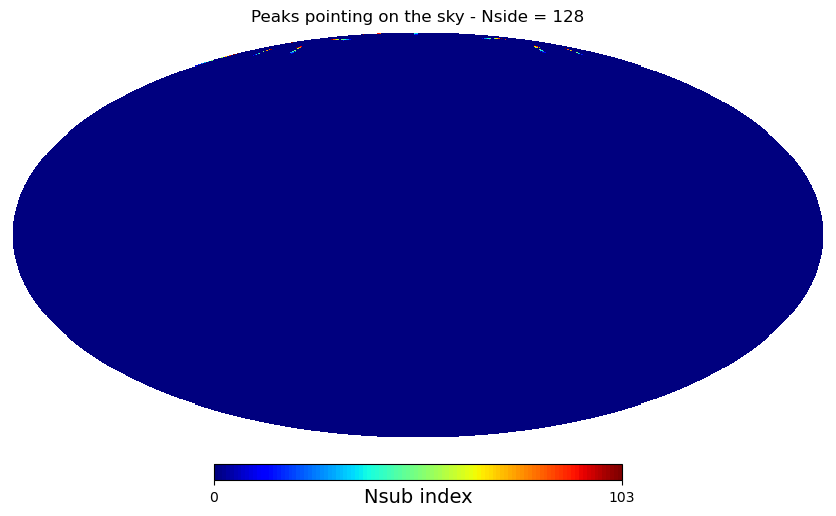

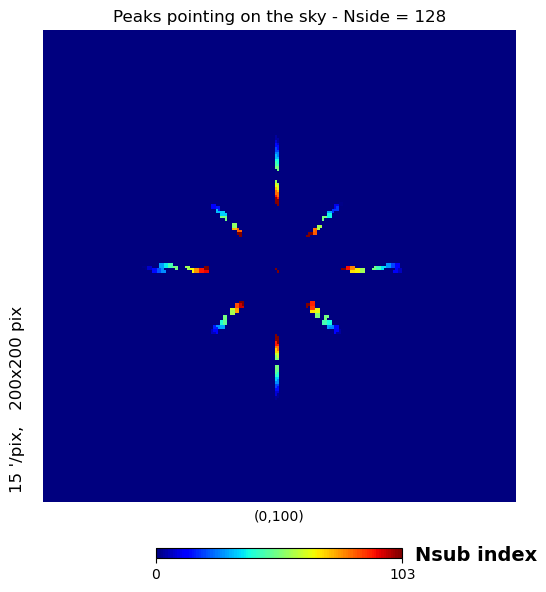

In [9]:
# Plot the projection of the peaks on the sky
test = np.zeros(hp.nside2npix(nside))

for i in range(np.shape(peaks_index_list[-1])[0]):
    test[peaks_index_list[-1][i, 0]] = i

colors = plt.cm.jet(np.linspace(0, 1, nsub))
hp.mollview(test, title=f"Peaks pointing on the sky - Nside = {nside}", cmap=plt.cm.colors.ListedColormap(colors), unit="Nsub index")
hp.gnomview(test, reso=15, rot=[0, 100], title=f"Peaks pointing on the sky - Nside = {nside}", cmap=plt.cm.colors.ListedColormap(colors), unit="Nsub index")

# Plot TOD

(131.25, 245.0)

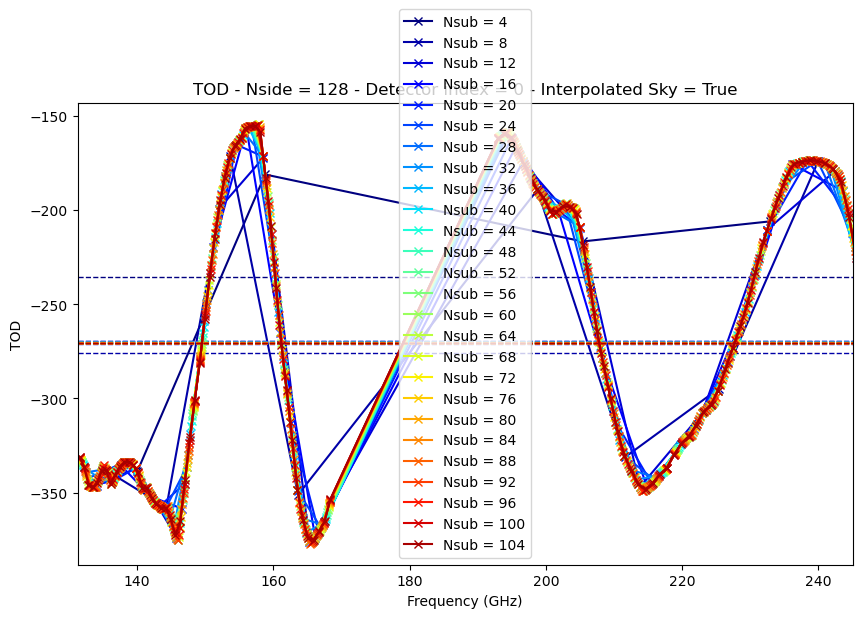

In [10]:
plt.figure(figsize=(10, 6))

idet = 0

for isub in range(len(nsub_list)):
    color = plt.cm.jet(isub/len(nsub_list))
    plt.plot(freq_list[isub], tod_list_w_interp[isub][:, idet], '-x', color=color, label=f"Nsub = {nsub_list[isub]}")
    plt.hlines(np.mean(tod_list_w_interp[isub][:, idet]), xmin=131.25, xmax=245, color=color, linestyle='--', linewidth=1)
    
plt.title(f"TOD - Nside = {nside} - Detector index = {idet} - Interpolated Sky = True")
plt.xlabel("Frequency (GHz)")
plt.ylabel("TOD")
plt.legend(loc='best')
plt.xlim(131.25, 245)

(131.25, 245.0)

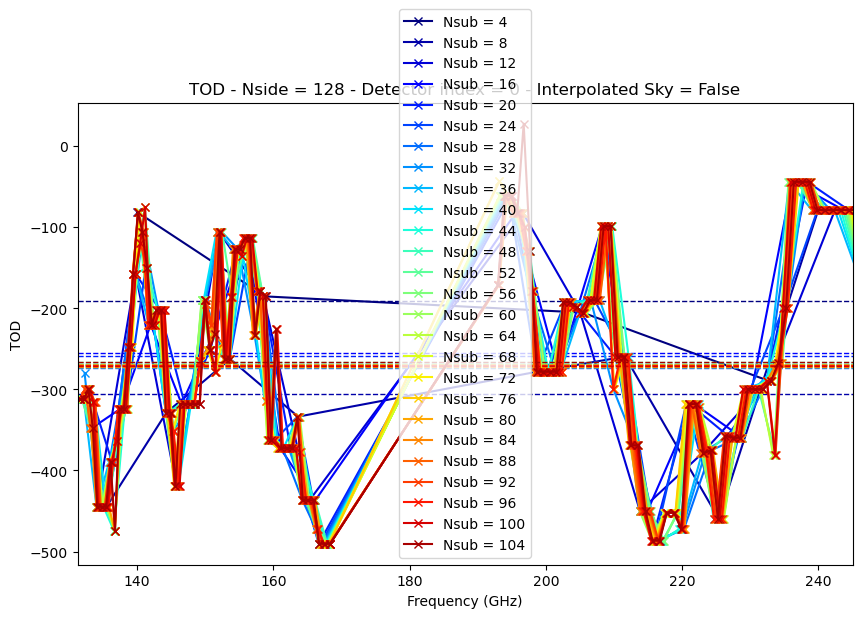

In [11]:
plt.figure(figsize=(10, 6))

idet = 0

for isub in range(len(nsub_list)):
    color = plt.cm.jet(isub/len(nsub_list))
    plt.plot(freq_list[isub], tod_list_wo_interp[isub][:, idet], '-x', color=color, label=f"Nsub = {nsub_list[isub]}")
    plt.hlines(np.mean(tod_list_wo_interp[isub][:, idet]), xmin=131.25, xmax=245, color=color, linestyle='--', linewidth=1)
    
plt.title(f"TOD - Nside = {nside} - Detector index = {idet} - Interpolated Sky = False")
plt.xlabel("Frequency (GHz)")
plt.ylabel("TOD")
plt.legend(loc='best')
plt.xlim(131.25, 245)

Be careful, when I sum over the sub-tods, I have to multiply by the bandwidth of the sub-bands

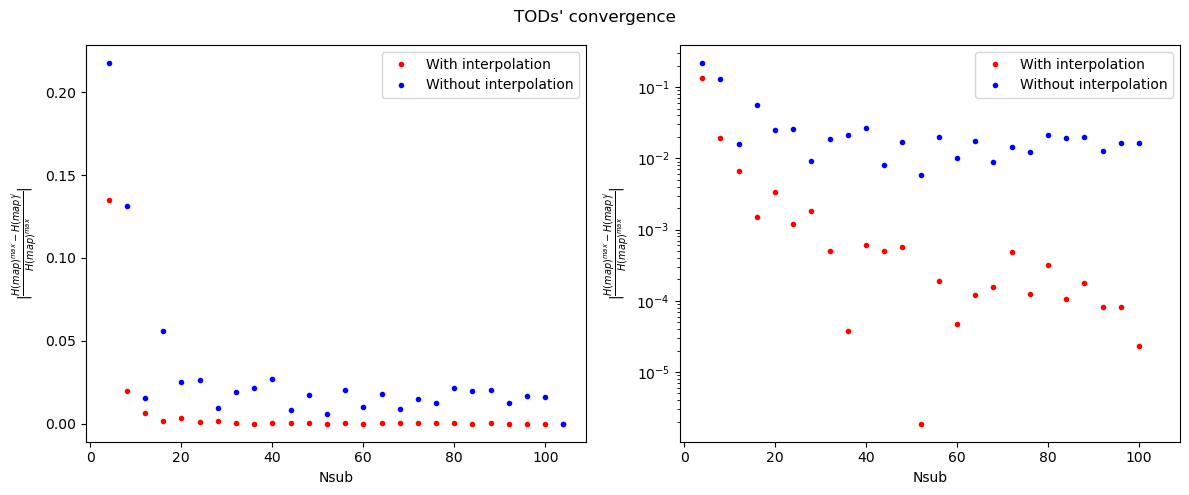

In [13]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

for i in range(len(tod_list_w_interp)):    
    rel_diff = (np.sum(tod_list_w_interp[i][:, idet]*bandwidth_list[i], axis = 0) - np.sum(tod_list_w_interp[-1][:, idet]*bandwidth_list[-1], axis = 0))/np.sum(tod_list_w_interp[-1][:, idet]*bandwidth_list[-1], axis = 0)
    ax1.plot(nsub_list[i], np.abs(rel_diff), '.r', label='With interpolation' if i == 0 else '')
    ax2.plot(nsub_list[i], np.abs(rel_diff), '.r', label='With interpolation' if i == 0 else '')
    
    rel_diff = (np.sum(tod_list_wo_interp[i][:, idet]*bandwidth_list[i], axis = 0) - np.sum(tod_list_wo_interp[-1][:, idet]*bandwidth_list[-1], axis = 0))/np.sum(tod_list_wo_interp[-1][:, idet]*bandwidth_list[-1], axis = 0)
    ax1.plot(nsub_list[i], np.abs(rel_diff), '.b', label='Without interpolation' if i == 0 else '')
    ax2.plot(nsub_list[i], np.abs(rel_diff), '.b', label='Without interpolation' if i == 0 else '')

for ax in [ax1, ax2]:
    ax.set_xlabel('Nsub')
    ax.set_ylabel(r'|$\frac{H(map)^{max} - H(map)^{i}}{H(map)^{max}}$|')
    ax.legend()

ax2.set_yscale('log')
fig.suptitle("TODs' convergence")
plt.tight_layout()
plt.show()